## **CENÁRIO 03: COMPLETO** 

IMPORTS

In [83]:
import pandas as pd
import simpy
import os
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
import matplotlib.patches as mpatches
from datetime import date, timedelta
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas


### **ETAPA 1 - Obtendo informações de tempo do Yamazumi**

In [84]:
# OBTENDO TEMPOS POR ATIVIDADES DOS ARQUIVOS YAMAZUMI 
def get_process_times_from_csv(arquivo):
    """Lê um CSV Yamazumi, extrai os tempos por atividade e retorna um dicionário {atividade: tempo_em_segundos}."""
    
    def converter_tempo_para_segundos(tempo_str):
        if pd.isna(tempo_str) or not isinstance(tempo_str, str):
            return 0
        parts = str(tempo_str).split(':')
        try:
            if len(parts) == 3:
                h, m, s = map(int, parts)
                return h * 3600 + m * 60 + s
            elif len(parts) == 2:
                m, s = map(int, parts)
                return m * 60 + s
        except Exception:
            return 0
        return 0

    if not os.path.exists(arquivo):
        return {}

    df = pd.read_csv(arquivo, header=5, sep=';', encoding='latin1', on_bad_lines='skip')

    def normalizar_coluna(col):
        col = unidecode(col)
        col = col.upper()
        col = re.sub(r"[\"\'().\-\/]", "", col)
        col = re.sub(r"\s+", "_", col)
        return col.strip("_")

    df.columns = [normalizar_coluna(col) for col in df.columns]

    class_col = next((col for col in df.columns if 'CLASSIFICA' in col), None)
    if not class_col:
        return {}

    total_row = df[df[class_col] == 'Total'].copy()
    if total_row.empty:
        return {}

    start_col = df.columns.get_loc(class_col) + 1
    end_col = len(df.columns)
    try:
        end_col = df.columns.get_loc('COLUNA1')
    except KeyError:
        pass

    colunas_postos = df.columns[start_col:end_col]
    tempos_totais = total_row[colunas_postos].dropna(axis=1, how='all')
    tempos_formatados = tempos_totais.melt(var_name='Atividade', value_name='Tempo_str')
    tempos_formatados['Tempo_segundos'] = tempos_formatados['Tempo_str'].apply(converter_tempo_para_segundos)

    return pd.Series(tempos_formatados.Tempo_segundos.values, index=tempos_formatados.Atividade).to_dict()



### ETAPA 02: Criando dicionário de tempos por posto

##### Configuração perna 1: 
19 operadores no total sendo 1 por atividade, com excessões: 
- DIESEL - 30A  
- ARREFEC - 31A  
- REAPERTO - 32A  
- 5AA_RODA - 32C (só ATP)  
- ESTEPE - 32C  
- PNEU_LE + PNEU_LD - 33A (2 operadores)  
- APERTO_LE + APERTO_LD - 34A (2 operadores)  
- GRADE- 34A  
- MECACNICA_1 + MECACNICA_2 - Início: 34A; Fim: 38 (2 operadores)  
- ELECTRICA_1 + ELECTRICA_2 - Início: 32A; Fim: 33A (2 operadores)  
- CONTROLE - 34A  
- MOTORISTA - 38  
- QUIS - 38  




##### Configuração perna 2:
13 operadores no total sendo 1 por atividade, com excessões: 
- PASSADISASSO - 30B 
- ABASTECIMENTO - 31B   
- CHINELEIRA - 32B  
- 5AA_RODA - 32D  
- PNEU_LE + PNEU_LD - 33B (2 operadores)  
- PARALAMA_LD + PARALAMA_LE - 34B (1 op)  
Paralama e pneu é feito ao mesmo tempo, assim, tempo paralama conta como 1
- CONTROLE - 34B 
- ELACTRICA_I + ELACTRICA_II + ELACTRICA_III - Início: 33B; Fim: 39 (3 operadores)  
Na elétrica, podemos considerar como se 1 operador fizesse 1 atvidade total distribuída pelos 3 postos  


In [85]:

# --- Dicionários ---
#Adaptação para o cenário 3
MODELOS_CSV = {
    "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "tempos": "Yamazumi - Accelo.csv"},
    "Atego": {"baumuster":["C951500", "C951511", "C951514"], "tempos":"Yamazumi - Atego.csv"},
    "Atego 8x2 e 8x4": {"baumuster":["C951530", "C951544"], "tempos":"Yamazumi - Atego.csv"},
    "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "tempos":"Yamazumi - ATP.csv"}, 
    "Atego quinta roda": {"baumuster": ["C951501"], "tempos":"Yamazumi - ATP.csv"},
    "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "tempos":"Yamazumi - Actros.csv"},
    "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "tempos":"Yamazumi - Arocs.csv"},
    "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "tempos": "Yamazumi - Actros.csv"}
}
# MODELOS_CSV = {
#     "Accelo": {"baumuster": ["C951102", "C951104", "C951111"], "perna": 1, "tempos": "Yamazumi - Accelo.csv"},
#     "Atego": {"baumuster":["C951500", "C951511", "C951514"],"perna": 1, "tempos":"Yamazumi - Atego.csv"},
#     "Atego 8x2 e 8x4": {"baumuster":["C951530", "C951544"],"perna": 2, "tempos":"Yamazumi - Atego.csv"},
#     "Atego (ATP)":{"baumuster": ["C968403", "C968114"], "perna": 2, "tempos":"Yamazumi - ATP.csv"}, 
#     "Atego quinta roda": {"baumuster": ["C951501"], "perna": 2, "tempos":"Yamazumi - ATP.csv"},
#     "Actros":{"baumuster": ["C963400", "C963403", "C963411", "C963414", "C963424", "C963425"], "perna": 2, "tempos":"Yamazumi - Actros.csv"},
#     "Arocs": {"baumuster":["C964016", "C964216", "C964231", "C964416"], "perna": 2, "tempos":"Yamazumi - Arocs.csv"},
#     "Axor (ATP +)":{"baumuster": ["C968150", "C968450", "C968453", "C968461", "C968475"], "perna":2, "tempos": "Yamazumi - Actros.csv"}
# }

#Remoção do Atego (ATP)
# ATIVIDADES_P1 = {'DIESEL':{'postos':['30A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'ARREFEC':{'postos':['31A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'REAPERTO':{'postos':['32A'],'modelos':['Accelo','Atego'],'operadores':1},
#               '5AA_RODA':{'postos':['32C'],'modelos':['Accelo','Atego'],'operadores':1},
#               'ESTEPE':{'postos':['32C'],'modelos':['Accelo','Atego'],'operadores':1},
#               'APERTO_LE':{'postos':['32C'],'modelos':['Accelo','Atego'],'operadores':1},
#               'PNEU_LD':{'postos':['33A'],'modelos':['Accelo','Atego'],'operadores':1}, 
#               'PNEU_LE':{'postos':['33A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'APERTO_LD':{'postos':['34A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'GRADE':{'postos':['34A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'MECACNICA_1':{'postos':['34A','38'],'modelos':['Accelo','Atego'],'operadores':1},
#               'MECACNICA_2':{'postos':['34A','38'],'modelos':['Accelo','Atego'],'operadores':1},
#               'ELACTRICA_1':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'ELACTRICA_2':{'postos':['32A','32C','33A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'CONTROLE':{'postos':['34A'],'modelos':['Accelo','Atego'],'operadores':1},
#               'MOTORISTA':{'postos':['38'],'modelos':['Accelo','Atego'],'operadores':1},
#               'QUIS':{'postos':['38'],'modelos':['Accelo','Atego'],'operadores':1},
#               }

# #Adicionar novos carros que vão pra perna 2 e adaptar os postos da p1 paralelos a p2
# ATIVIDADES_P2 = {'PASSADISASSO':{'postos':['30B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
#               'ABASTECIMENTO':{'postos':['31B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
#               'CHINELEIRA':{'postos':['32B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
#               '5AA_RODA': {'postos':['32D'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'PNEU_LD':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego''Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1}, 
#               'PNEU_LE':{'postos':['33B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Accelo','Atego''Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'PARALAMA_LD': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},#mesmo operador que o de aperto_ld e le
#               'PARALAMA_LE':{'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
#               'CONTROLE': {'postos':['34B'],'modelos':['Actros','Arocs', 'Axor (ATP +)','Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'ELACTRICA_I':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
#               'ELACTRICA_II':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':1},
#               'ELACTRICA_III':{'postos':['33B','34B','39'],'modelos':['Actros','Arocs', 'Axor (ATP +)'],'operadores':0},
              
#               #Atividades da p1 que foram para a p2
#               'DIESEL':{'postos':['30B'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'ARREFEC':{'postos':['31B'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'REAPERTO':{'postos':['32B'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'ESTEPE':{'postos':['32D'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'APERTO_LE':{'postos':['32D'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'APERTO_LD':{'postos':['34B'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'GRADE':{'postos':['34B'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'MECACNICA_1':{'postos':['34B','39'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'MECACNICA_2':{'postos':['34A','39'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'ELACTRICA_1':{'postos':['33B','34B','39'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'ELACTRICA_2':{'postos':['33B','34B','39'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'MOTORISTA':{'postos':['39'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#               'QUIS':{'postos':['39'],'modelos':['Atego 8x2 e 8x4','Atego (ATP)', 'Atego quinta roda'],'operadores':1},
#                }
ATIVIDADES = {
    # Atividades da Perna 1
    'DIESEL_P1':{'postos':['30A'], 'operadores':1},
    'ARREFEC_P1':{'postos':['31A'], 'operadores':1},
    'REAPERTO_P1':{'postos':['32A'], 'operadores':1},
    '5AA_RODA_P1':{'postos':['32C'], 'operadores':1},
    'ESTEPE_P1':{'postos':['32C'], 'operadores':1},
    'APERTO_LE_P1':{'postos':['32C'], 'operadores':1},
    'PNEU_LD_P1':{'postos':['33A'], 'operadores':1}, 
    'PNEU_LE_P1':{'postos':['33A'], 'operadores':1},
    'APERTO_LD_P1':{'postos':['34A'], 'operadores':1},
    'GRADE_P1':{'postos':['34A'], 'operadores':1},
    'MECACNICA_1_P1':{'postos':['34A','38'], 'operadores':1},
    'MECACNICA_2_P1':{'postos':['34A','38'], 'operadores':1},
    'ELACTRICA_1_P1':{'postos':['32A','32C','33A'], 'operadores':1},
    'ELACTRICA_2_P1':{'postos':['32A','32C','33A'], 'operadores':1},
    'CONTROLE_P1':{'postos':['34A'], 'operadores':1},
    'MOTORISTA_P1':{'postos':['38'], 'operadores':1},
    'QUIS_P1':{'postos':['38'], 'operadores':1},
    
    # Atividades da Perna 2
    'PASSADISASSO_P2':{'postos':['30B'], 'operadores':1},
    'ABASTECIMENTO_P2':{'postos':['31B'], 'operadores':1},
    'CHINELEIRA_P2':{'postos':['32B'], 'operadores':1},
    '5AA_RODA_P2': {'postos':['32D'], 'operadores':1},
    'PNEU_LD_P2':{'postos':['33B'], 'operadores':1}, 
    'PNEU_LE_P2':{'postos':['33B'], 'operadores':1},
    'PARALAMA_LD_P2': {'postos':['34B'], 'operadores':1},
    'PARALAMA_LE_P2':{'postos':['34B'], 'operadores':1},
    'CONTROLE_P2': {'postos':['34B'], 'operadores':1},
    'ELACTRICA_I_P2':{'postos':['33B','34B','39'], 'operadores':1},
    'ELACTRICA_II_P2':{'postos':['33B','34B','39'], 'operadores':1},
    'ELACTRICA_III_P2':{'postos':['33B','34B','39'], 'operadores':0},
    'DIESEL_P2':{'postos':['30B'], 'operadores':1},
    'ARREFEC_P2':{'postos':['31B'], 'operadores':1},
    'REAPERTO_P2':{'postos':['32B'], 'operadores':1},
    'ESTEPE_P2':{'postos':['32D'], 'operadores':1},
    'APERTO_LE_P2':{'postos':['32D'], 'operadores':1},
    'APERTO_LD_P2':{'postos':['34B'], 'operadores':1},
    'GRADE_P2':{'postos':['34B'], 'operadores':1},
    'MECACNICA_1_P2':{'postos':['34B','39'], 'operadores':1},
    'MECACNICA_2_P2':{'postos':['34A','39'], 'operadores':1},
    'ELACTRICA_1_P2':{'postos':['33B','34B','39'], 'operadores':1},
    'ELACTRICA_2_P2':{'postos':['33B','34B','39'], 'operadores':1},
    'MOTORISTA_P2':{'postos':['39'], 'operadores':1},
    'QUIS_P2':{'postos':['39'], 'operadores':1},
}

In [86]:
def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES, GRUPOS_ESPECIAIS, get_process_times_from_csv):
    """
    Gera o dicionário de postos e tempos de ciclo para cada modelo, calculando
    uma rota potencial para a Perna 1 e para a Perna 2.
    """
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    POSTOS = {}

    for modelo, dados_modelo in MODELOS_CSV.items():
        POSTOS[modelo] = {1: {}, 2: {}}  # Estrutura para Perna 1 e Perna 2
        arquivo = dados_modelo["tempos"]
        tempos_atividade_raw = get_process_times_from_csv(arquivo)
        
        # Itera para processar a rota da Perna 1 e depois a da Perna 2 para o mesmo modelo
        for perna, ordem_postos, grupos in [(1, ordem_P1, GRUPOS_ESPECIAIS['P1']), (2, ordem_P2, GRUPOS_ESPECIAIS['P2'])]:
            
            dicionario_postos_perna = defaultdict(float)
            
            # Cria um dicionário de atividades apenas para a perna atual
            atividades_perna = {}
            for nome_atividade, props in ATIVIDADES.items():
                if f'_P{perna}' in nome_atividade:
                    nome_base = nome_atividade.replace(f'_P{perna}', '')
                    atividades_perna[nome_base] = props

            # Filtra os tempos do Yamazumi apenas para atividades que realmente existem
            tempos_atividade_modelo = {k: v for k, v in tempos_atividade_raw.items()}

            atividades_processadas_em_grupo = set()

            # 1. Processa os grupos especiais primeiro
            for nome_grupo, grupo in grupos.items():
                atividades_do_grupo = grupo["atividades"]
                # Verifica se todas as atividades do grupo existem no Yamazumi do modelo
                if not all(a in tempos_atividade_modelo and a in atividades_perna for a in atividades_do_grupo):
                    continue
                
                atividades_processadas_em_grupo.update(atividades_do_grupo)
                
                tempo = 0
                if grupo["agreg"] == "media":
                    tempo_total_op = sum(tempos_atividade_modelo[a] / atividades_perna[a]['operadores'] for a in atividades_do_grupo)
                    tempo = tempo_total_op / len(atividades_do_grupo)
                elif grupo["agreg"] == "paralama":
                    tempo_total = sum(tempos_atividade_modelo[a] for a in atividades_do_grupo)
                    # A regra original dividia por operadores/2, mantendo como exemplo
                    total_operadores = sum(atividades_perna[a]['operadores'] for a in atividades_do_grupo) / 2
                    tempo = tempo_total / total_operadores if total_operadores > 0 else 0
                elif grupo["agreg"] == "novo":
                    tempo_total = sum(tempos_atividade_modelo[a] for a in atividades_do_grupo)
                    total_operadores = 1
                    tempo = tempo_total / total_operadores

                postos_do_grupo = set(p for a in atividades_do_grupo for p in atividades_perna[a]['postos'])
                if postos_do_grupo:
                    for posto in postos_do_grupo:
                        dicionario_postos_perna[posto] += tempo / len(postos_do_grupo)

            # 2. Processa as atividades individuais que não estavam em grupos
            for atividade, props in atividades_perna.items():
                if atividade in tempos_atividade_modelo and atividade not in atividades_processadas_em_grupo:
                    if props['operadores'] > 0:
                      tempo_calculado = tempos_atividade_modelo[atividade] / props['operadores']
                      for posto in props['postos']:
                          dicionario_postos_perna[posto] += tempo_calculado

            # 3. Monta o dicionário final ordenado para a perna
            postos_ordenados = {}
            for posto in ordem_postos:
                if posto in dicionario_postos_perna and dicionario_postos_perna[posto] > 0:
                    postos_ordenados[posto] = {"tempo_tot": dicionario_postos_perna[posto], "perna": perna}
            
            POSTOS[modelo][perna] = postos_ordenados

    return POSTOS, None

In [87]:
# def gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     POSTOS = {}

#     GRUPOS_ESPECIAIS = {
#         'P1': {
#             'PNEU_1': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'APERTO_1': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "novo"},
#             'MECACNICA_1': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
#             'ELETRICA_1': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"}
#         },
#         'P2': {
#             'PNEU_2': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
#             'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "novo"},
#             'ELETRICA_2': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II'], "agreg": "novo"},
#             'APERTO_2': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "paralama"},
#             'MECACNICA_2': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "novo"},
#             'ELECTRICA_2': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "novo"},
#             'DIESEL_PASSADISSO': {'atividades': ['DIESEL', 'PASSADISASSO'], 'agreg': 'novo'},
#             'ARREFEC_ABASTECIMENTO': {'atividades': ['ARREFEC', 'ABASTECIMENTO'], 'agreg': 'novo'},
#             'REAPERTO_CHINELEIRA': {'atividades': ['REAPERTO', 'CHINELEIRA'], 'agreg': 'novo'},
#             '5AA_RODA_ESTEPE': {'atividades': ['ESTEPE', '5AA_RODA'], 'agreg': 'novo'},
#             'GRADE_CONTROLE':{'atividades': ['GRADE','CONTROLE'], 'agreg': 'novo'},
#             'MOTORISTA_QUIS': {'atividades': ['MOTORISTA', 'QUIS'], 'agreg': 'novo'},
#         }
#     }

#     atividades_unicas_por_perna = {1: set(), 2: set()}

#     for modelo, dados_modelo in MODELOS_CSV.items():
#         #print(modelo)
#         perna = dados_modelo["perna"]
#         arquivo = dados_modelo["tempos"]
#         tempos_atividade = get_process_times_from_csv(arquivo)

#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         ordem_postos = ordem_P1 if perna == 1 else ordem_P2
#         grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

#         dicionario_postos = {}

#         for nome_grupo, grupo in grupos.items():
#             atividades = grupo["atividades"]
#             if not all(a in tempos_atividade and a in atividades_dict for a in atividades):
#                 continue

#             for a in atividades:
#                 atividades_unicas_por_perna[perna].add(a)

#             if grupo["agreg"] == "media":
#                 tempo_total = sum(tempos_atividade[a] / atividades_dict[a]['operadores'] for a in atividades)
#                 tempo = tempo_total / len(atividades)
#             elif grupo["agreg"] == "paralama":
#                 tempo_total = sum(tempos_atividade[a] for a in atividades)
#                 total_operadores = sum(atividades_dict[a]['operadores'] for a in atividades)/2
#                 tempo = tempo_total / total_operadores
#             elif grupo["agreg"] == "novo":
#                 tempo_total = sum(tempos_atividade[a] for a in atividades)
#                 total_operadores = 1  # REGRA NOVA: apenas 1 operador realiza todas as atividades do grupo
#                 tempo = tempo_total / total_operadores
#             else:
#                 continue

#             postos_grupo = set(p for a in atividades for p in atividades_dict[a]['postos'])
#             for posto in postos_grupo:
#                 dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
#                 dicionario_postos[posto]["tempo_tot"] += tempo / len(postos_grupo)

#         for atividade, props in atividades_dict.items():
#             if modelo not in props['modelos']:
#                 continue
#             if atividade not in tempos_atividade:
#                 continue

#             atividades_unicas_por_perna[perna].add(atividade)

#             tempo = tempos_atividade[atividade] / props['operadores']
#             for posto in props['postos']:
#                 dicionario_postos.setdefault(posto, {"tempo_tot": 0, "perna": perna})
#                 dicionario_postos[posto]["tempo_tot"] += tempo

#         postos_ordenados = {}
#         for posto in ordem_postos:
#             if posto in dicionario_postos:
#                 postos_ordenados[posto] = dicionario_postos[posto]

#         POSTOS[modelo] = postos_ordenados
#     operadores = {1: 0, 2: 0}
#     for perna in [1, 2]:
#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         grupos = GRUPOS_ESPECIAIS['P1'] if perna == 1 else GRUPOS_ESPECIAIS['P2']

#         # Atividades já consideradas via grupo 'novo'
#         atividades_em_grupos_novo = set()
#         for grupo in grupos.values():
#             if grupo['agreg']=='novo':
#                 atividades_em_grupos_novo.update(grupo["atividades"])
#                 operadores[perna] += 1  # Conta apenas 1 operador por grupo 'novo'
#         print(atividades_em_grupos_novo)

#         # Agora conta as atividades que não fazem parte de grupo 'novo'
#         for atividade in atividades_unicas_por_perna[perna]:
#             if atividade not in atividades_em_grupos_novo:
#                 #print(atividade,atividades_dict[atividade]['operadores'])
#                 operadores[perna] += atividades_dict[atividade]["operadores"]

#     print(f"\n👷‍♂️ Operadores totais por perna:")
#     for perna in [1, 2]:
#         print(f"  Perna {perna}: {operadores[perna]} operadores")

#     return POSTOS, operadores


In [88]:
def calcular_pool_operadores(ATIVIDADES, GRUPOS_ESPECIAIS):
    """
    Calcula o número total de operadores necessários para cobrir todas as atividades
    e grupos, assumindo uma equipe flexível.
    """
    operadores_por_grupo = 0
    atividades_em_grupo = set()

    # 1. Contar operadores de GRUPOS que agregam trabalho
    for perna in ['P1', 'P2']:
        for nome_grupo, grupo in GRUPOS_ESPECIAIS[perna].items():
            if grupo['agreg'] in ['novo', 'paralama']:
                operadores_por_grupo += 1
                # Usamos os nomes base das atividades para evitar duplicatas
                atividades_em_grupo.update(grupo['atividades'])

    # 2. Contar operadores para atividades individuais
    operadores_individuais = 0
    atividades_unicas_contadas = set()
    atividades_simples = {}
    for nome, props in ATIVIDADES.items():
        nome_base = nome.replace('_P1', '').replace('_P2', '')
        atividades_simples[nome_base] = props

    for nome_base, props in atividades_simples.items():
        if nome_base not in atividades_em_grupo and nome_base not in atividades_unicas_contadas:
            operadores_individuais += props['operadores']
            atividades_unicas_contadas.add(nome_base)

    # --- LINHA CORRIGIDA ADICIONADA AQUI ---
    total_operadores = operadores_por_grupo + operadores_individuais
    
    print(f"--- Análise de Mão de Obra (Estimativa Estática) ---")
    print(f"👷‍♂️ Pool Total de Operadores Estimado: {total_operadores}")
    print(f"   - Operadores em Funções Agrupadas: {operadores_por_grupo}")
    print(f"   - Operadores em Funções Individuais: {operadores_individuais}")
    print("----------------------------------------------------")
    
    return total_operadores

In [89]:
# POSTOS, operadores = gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv)
# for modelo, valor in POSTOS.items():
#     print(f"{modelo}: {valor}")

GRUPOS_ESPECIAIS = {
    'P1': {
        'PNEU_1': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
        'APERTO_1': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "novo"},
        'MECACNICA_1': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "media"},
        'ELETRICA_1': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "media"}
    },
    'P2': {
        'PNEU_2': {"atividades": ['PNEU_LE', 'PNEU_LD'], "agreg": "media"},
        'PARALAMA': {"atividades": ['PARALAMA_LE', 'PARALAMA_LD'], "agreg": "novo"},
        'ELETRICA_2': {"atividades": ['ELACTRICA_I', 'ELACTRICA_II'], "agreg": "novo"},
        'APERTO_2': {"atividades": ['APERTO_LE', 'APERTO_LD'], "agreg": "paralama"},
        'MECACNICA_2': {"atividades": ['MECACNICA_1', 'MECACNICA_2'], "agreg": "novo"},
        'ELECTRICA_2': {"atividades": ['ELACTRICA_1', 'ELACTRICA_2'], "agreg": "novo"},
        'DIESEL_PASSADISSO': {'atividades': ['DIESEL', 'PASSADISASSO'], 'agreg': 'novo'},
        'ARREFEC_ABASTECIMENTO': {'atividades': ['ARREFEC', 'ABASTECIMENTO'], 'agreg': 'novo'},
        'REAPERTO_CHINELEIRA': {'atividades': ['REAPERTO', 'CHINELEIRA'], 'agreg': 'novo'},
        '5AA_RODA_ESTEPE': {'atividades': ['ESTEPE', '5AA_RODA'], 'agreg': 'novo'},
        'GRADE_CONTROLE':{'atividades': ['GRADE','CONTROLE'], 'agreg': 'novo'},
        'MOTORISTA_QUIS': {'atividades': ['MOTORISTA', 'QUIS'], 'agreg': 'novo'},
    }
}


TAKT_TIME = 5.5 * 60
TURN_DURATION = 14 * 3600

# --- Preparação e Análise Estática ---


total_operadores_estimado = calcular_pool_operadores(ATIVIDADES, GRUPOS_ESPECIAIS)


POSTOS, _ = gerar_dicionario_postos(MODELOS_CSV, ATIVIDADES, GRUPOS_ESPECIAIS, get_process_times_from_csv)


print("\n--- Roteiros de Produção Gerados ---")
for modelo, pernas in POSTOS.items():
    print(f"\nModelo: {modelo}")
    for perna, rota in pernas.items():
        if rota: # Só imprime se a rota para a perna não for vazia
            print(f"  Perna {perna}: Rota com {len(rota)} postos.")
        else:
            print(f"  Perna {perna}: Sem rota definida.")
print("------------------------------------")

--- Análise de Mão de Obra (Estimativa Estática) ---
👷‍♂️ Pool Total de Operadores Estimado: 14
   - Operadores em Funções Agrupadas: 12
   - Operadores em Funções Individuais: 2
----------------------------------------------------

--- Roteiros de Produção Gerados ---

Modelo: Accelo
  Perna 1: Rota com 7 postos.
  Perna 2: Rota com 7 postos.

Modelo: Atego
  Perna 1: Rota com 7 postos.
  Perna 2: Rota com 7 postos.

Modelo: Atego 8x2 e 8x4
  Perna 1: Rota com 7 postos.
  Perna 2: Rota com 7 postos.

Modelo: Atego (ATP)
  Perna 1: Rota com 7 postos.
  Perna 2: Rota com 7 postos.

Modelo: Atego quinta roda
  Perna 1: Rota com 7 postos.
  Perna 2: Rota com 7 postos.

Modelo: Actros
  Perna 1: Rota com 3 postos.
  Perna 2: Rota com 7 postos.

Modelo: Arocs
  Perna 1: Rota com 3 postos.
  Perna 2: Rota com 7 postos.

Modelo: Axor (ATP +)
  Perna 1: Rota com 3 postos.
  Perna 2: Rota com 7 postos.
------------------------------------


### ETAPA 03: Processamento da simulação 

In [90]:
# TAKT_TIME=5.5*60
# TURN_DURATION=14*3600

# # Função PROCESSAR_MODELO() simula a trajetória de um modelo pela linha de montagem:
# # env é o ambiente de simulação do SimPy.
# # nome é o nome único desse modelo na simulação, ex: "Actros_5".
# # postos_dict é um dicionário com os postos que esse modelo vai passar, com tempos por posto.

# log_entrada_saida=[]
# def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos):
#     for posto, dados in postos_dict.items():
#         tempo_tot = dados["tempo_tot"]
#         with recursos[posto].request() as req: # pede o recurso do posto (garante que só um modelo usa por vez)
#             entrada = env.now
#             yield req #espera se necessário (yield req)
#             yield env.timeout(tempo_tot) # espera o tempo de montagem (yield env.timeout(tempo_tot))
#             saida = env.now

#             # registra entrada, saída e duração no log
#             log_entrada_saida.append({
#                 "modelo": modelo_nome,
#                 "nome": nome,
#                 "posto": posto,
#                 "entrada": entrada,
#                 "saida": saida,
#                 "duracao": saida - entrada,
#                 "perna": perna
#             })

# # Função SIMULACAO_LINHA cria o ambiente da simulação
# # recursos: dicionário onde cada posto é um simpy.Resource() com capacity=1.
# # ultimo_tempo_entrada_global: impede que dois modelos entrem no mesmo instante.
# # disponibilidade_postos: controla quando o primeiro posto da perna estará livre para o próximo veículo.

# def simulacao_linha(sequencia_modelos, MODELOS_CSV, resultado, TAKT_TIME, TURN_DURATION):

#     env = simpy.Environment() # criando ambiente simulação
    
#     # Ferramentas auxiliares na função:
#     recursos = {} # dicionário onde cada posto é um simpy.Resource() com capacity=1;nenhum posto pode ser ocupado por mais de um modelo
#     ultimo_tempo_entrada_global = 0  # ninguém entra na linha antes disso, impede que dois modelos entrem no mesmo instante nas pernas
#     disponibilidade_postos = {}  # armazena quando o primeiro posto de cada perna estará livre para próximo veículo entrar

#     # Função ALIMENTADOR() coloca os modelos na linha, respeitando o espaçamento (TAKT) e disponibilidade do primeiro posto.
#     def alimentador(env):
#         nonlocal ultimo_tempo_entrada_global

#         # Identificando qual modelo corresponde ao baumuster da sequência e sua perna
#         for i, baumuster in enumerate(sequencia_modelos):
#             modelo_nome, perna = None, None
#             for nome, dados in MODELOS_CSV.items():
#                 if baumuster in dados["baumuster"]:
#                     modelo_nome = nome
#                     perna = dados["perna"]
#                     break
#             if modelo_nome is None:
#                 continue
            
#             # Define o primeiro posto que o modelo ocupará e quanto tempo levará nesse posto
#             postos_dict = resultado[modelo_nome]
#             primeiro_posto = next(iter(postos_dict))
#             tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto]["tempo_tot"]

#             # Inicializa a disponibilidade se for a primeira vez usando esse posto
#             if primeiro_posto not in disponibilidade_postos:
#                 disponibilidade_postos[primeiro_posto] = 0
            
#             # só entra um modelo por vez no primeiro posto de cada perna;
#             # o espaçamento entre modelos é de ao menos TAKT_TIME;
#             # respeita o tempo mínimo em que o posto estará livre.

#             # Espera até que seja possível entrar na linha
#             tempo_disponivel_posto = disponibilidade_postos[primeiro_posto]
#             entrada_sugerida = max(
#                 env.now,
#                 ultimo_tempo_entrada_global + TAKT_TIME,  # garante espaçamento global
#                 tempo_disponivel_posto  # garante que o primeiro posto da perna está livre
#             )

#             yield env.timeout(entrada_sugerida - env.now)

#             # Atualiza os controles de entrada
#             ultimo_tempo_entrada_global = entrada_sugerida
#             disponibilidade_postos[primeiro_posto] = entrada_sugerida + tempo_ciclo_primeiro_posto

#             # Cria os recursos dos postos, se necessário (caso não tenha sido criado)
#             for posto in postos_dict:
#                 if posto not in recursos:
#                     recursos[posto] = simpy.Resource(env, capacity=1)

#             # Inicia processo de montagem
#             env.process(processar_modelo(
#                 env=env,
#                 nome=f"{modelo_nome}_{i}",
#                 modelo_nome=modelo_nome,
#                 perna=perna,
#                 postos_dict=postos_dict,
#                 recursos=recursos
#             ))
    
#     # Inicia simulação, rodando até duração do turno
#     env.process(alimentador(env))
#     env.run(until=TURN_DURATION)
#     return pd.DataFrame(log_entrada_saida)

# --- Funções do Motor de Simulação ---

def processar_modelo(env, nome, modelo_nome, perna, postos_dict, recursos, log_simulacao):
    """
    Simula a passagem de um único modelo pelos seus postos de trabalho.
    Esta função está correta e não precisa de mudanças, apenas recebe o log como argumento.
    """
    for posto, dados in postos_dict.items():
        tempo_tot = dados["tempo_tot"]
        with recursos[posto].request() as req:
            entrada = env.now
            yield req
            yield env.timeout(tempo_tot)
            saida = env.now
            
            # Registra o evento no log específico desta simulação
            log_simulacao.append({
                "modelo": modelo_nome, "nome": nome, "posto": posto,
                "entrada": entrada, "saida": saida, "duracao": saida - entrada,
                "perna": perna
            })

def simulacao_linha(sequencia_modelos, MODELOS_CSV, postos_gerais, TAKT_TIME, TURN_DURATION):
    """
    Cria e executa o ambiente de simulação para uma sequência de produção.
    Esta função foi reescrita para incluir a lógica de balanceamento dinâmico de pernas.
    """
    env = simpy.Environment()
    recursos = {}
    log_desta_simulacao = []  # O log agora é local, para cada simulação ser independente
    
    # Dicionário para rastrear a disponibilidade dos postos de entrada de cada perna
    disponibilidade_postos_entrada = defaultdict(float)
    
    # Identifica os postos de entrada para facilitar a leitura do código
    PRIMEIRO_POSTO_P1 = '30A'
    PRIMEIRO_POSTO_P2 = '30B'

    # Função interna que alimenta a linha de produção
    def alimentador(env):
        ultimo_tempo_entrada_global = 0

        for i, baumuster in enumerate(sequencia_modelos):
            # Encontra o nome do modelo correspondente ao baumuster
            modelo_nome = next((nome for nome, dados in MODELOS_CSV.items() if baumuster in dados["baumuster"]), None)
            if not modelo_nome:
                continue

            # --- LÓGICA DE DECISÃO DINÂMICA DA PERNA ---
            # 1. Verifica quando cada perna estará livre
            tempo_livre_p1 = disponibilidade_postos_entrada[PRIMEIRO_POSTO_P1]
            tempo_livre_p2 = disponibilidade_postos_entrada[PRIMEIRO_POSTO_P2]

            # 2. Verifica se o modelo tem rota para cada perna
            rota_p1_existe = bool(postos_gerais[modelo_nome][1])
            rota_p2_existe = bool(postos_gerais[modelo_nome][2])

            # 3. Decide qual perna usar
            perna_escolhida = None
            if rota_p1_existe and rota_p2_existe: # Se pode ir para ambas...
                perna_escolhida = 1 if tempo_livre_p1 <= tempo_livre_p2 else 2 # ...escolhe a mais livre
            elif rota_p1_existe:
                perna_escolhida = 1 # Só pode ir para a P1
            elif rota_p2_existe:
                perna_escolhida = 2 # Só pode ir para a P2
            else:
                # print(f"Aviso: Modelo {modelo_nome} não tem rota para nenhuma perna. Pulando.")
                continue

            # 4. Pega os dados da rota escolhida
            postos_dict = postos_gerais[modelo_nome][perna_escolhida]
            primeiro_posto_escolhido = next(iter(postos_dict))
            tempo_ciclo_primeiro_posto = postos_dict[primeiro_posto_escolhido]["tempo_tot"]
            
            # 5. Calcula o tempo de entrada, respeitando o Takt e a disponibilidade do posto
            tempo_disponivel_posto = disponibilidade_postos_entrada[primeiro_posto_escolhido]
            entrada_sugerida = max(
                env.now,
                ultimo_tempo_entrada_global + TAKT_TIME,
                tempo_disponivel_posto
            )
            
            # Aguarda até o momento calculado para entrar na linha
            if entrada_sugerida > env.now:
                yield env.timeout(entrada_sugerida - env.now)

            # 6. Atualiza os controles de tempo
            ultimo_tempo_entrada_global = entrada_sugerida
            disponibilidade_postos_entrada[primeiro_posto_escolhido] = entrada_sugerida + tempo_ciclo_primeiro_posto

            # Cria os recursos dos postos (estações de trabalho) se ainda não existirem
            for posto in postos_dict:
                if posto not in recursos:
                    recursos[posto] = simpy.Resource(env, capacity=1)

            # 7. Inicia o processo de montagem para este caminhão
            env.process(processar_modelo(
                env=env,
                nome=f"{modelo_nome}_{i}",
                modelo_nome=modelo_nome,
                perna=perna_escolhida,
                postos_dict=postos_dict,
                recursos=recursos,
                log_simulacao=log_desta_simulacao # Passa a lista de log local
            ))
    
    # Inicia o processo alimentador e roda a simulação
    env.process(alimentador(env))
    env.run(until=TURN_DURATION)
    
    # Retorna o log como um DataFrame do Pandas
    return pd.DataFrame(log_desta_simulacao)


### ETAPA 04 : Criando funções de resposta gráfica  

In [91]:
def plot_duracao_media_por_posto(df_log):
    """
    Gera gráficos de barras da duração média por posto para cada perna, com base em df_log.
    Retorna uma lista com duas figuras.
    """
    import matplotlib.pyplot as plt

    df_log = df_log.copy()
    df_log["duracao_min"] = df_log["duracao"] / 60  # segundos → minutos
    figs = []

    for perna, cor in zip([1, 2], ["turquoise", "purple"]):
        media_perna = df_log[df_log["perna"] == perna].groupby("posto")["duracao_min"].mean()

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.bar(media_perna.index, media_perna.values, color=cor)
        ax.set_title(f"Duração média por posto - Perna {perna}")
        ax.set_ylabel("Duração (min)")
        ax.set_xlabel("Posto")
        ax.set_xticklabels(media_perna.index, rotation=45)
        fig.tight_layout()

        figs.append(fig)

    return figs


In [92]:
def plot_modelos_por_perna(df_log):
    """
    Plota gráfico de barras com a quantidade de modelos únicos produzidos por perna.
    """
    modelos_por_perna = df_log.groupby("perna")["nome"].nunique()
    fig = plt.figure(figsize=(14, 5))
    modelos_por_perna.plot(kind='bar', color='skyblue')
    plt.title("Modelos Produzidos por Perna")
    plt.xlabel("Perna")
    plt.ylabel("Quantidade de Modelos")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return fig


In [93]:
def plot_modelos_produzidos(df_log):
    """
    Plota gráfico de barras com a quantidade de veículos produzidos por tipo de modelo.
    Retorna a figura.
    """
    modelos_produzidos = df_log.groupby("modelo")["nome"].nunique().sort_values(ascending=False)
    print(modelos_produzidos)

    fig, ax = plt.subplots(figsize=(15, 8))
    bars = ax.bar(modelos_produzidos.index, modelos_produzidos.values, color='navy')

    for i, valor in enumerate(modelos_produzidos):
        ax.text(i, valor + 0.2, f"{valor}", ha='center', va='bottom', fontsize=9)

    ax.set_title("Modelos Produzidos no Turno")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Quantidade de Veículos")
    ax.set_xticklabels(modelos_produzidos.index, rotation=45)

    fig.tight_layout()
    return fig


In [94]:
def plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION):
    """
    Plota heatmaps da eficiência por modelo e posto para cada perna, 
    ponderando pelo número de unidades produzidas por modelo.
    Retorna uma lista de figuras para salvar ou manipular externamente.
    """

    df = df_log.copy()
    df["duracao_min"] = df["duracao"] / 60

    # 1. Soma do tempo por modelo/posto/perna
    soma_tempo = df.groupby(["perna", "modelo", "posto"])["duracao_min"].sum().reset_index()

    # 2. Quantidade de veículos por modelo e perna
    qtd_modelos = df.groupby(["perna", "modelo"])["nome"].nunique().reset_index().rename(columns={"nome": "qtd"})

    # 3. Merge das duas tabelas
    eficiencia = pd.merge(soma_tempo, qtd_modelos, on=["perna", "modelo"], how="left")

    # 4. Tempo médio por veículo
    eficiencia["duracao_media"] = eficiencia["duracao_min"] / eficiencia["qtd"]

    # 5. Eficiência = tempo médio / turno
    eficiencia["eficiencia"] = (eficiencia["duracao_media"] / TURN_DURATION) * 100

    figs = []

    for perna in [1, 2]:
        data = eficiencia[eficiencia["perna"] == perna]

        modelos_perna = df[df["perna"] == perna]["modelo"].unique()
        postos_perna = df[df["perna"] == perna]["posto"].unique()

        full_index = pd.MultiIndex.from_product(
            [modelos_perna, postos_perna], names=["modelo", "posto"]
        )

        data = data.set_index(["modelo", "posto"]).reindex(full_index).reset_index()
        data["eficiencia"] = data["eficiencia"].fillna(0)

        heatmap_data = data.pivot(index="posto", columns="modelo", values="eficiencia")

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(heatmap_data, annot=True, fmt=".2%", cmap="RdPu", cbar=True, ax=ax)
        ax.set_title(f"Porcentagem de ocupação dos modelos por posto - Perna {perna}")
        ax.set_ylabel("Posto")
        ax.set_xlabel("Modelo")
        fig.tight_layout()
        
        figs.append(fig)  # adiciona a figura corretamente (não None)

    return figs


In [95]:

def plot_sequencia_modelos_heatmap(df_log):
    # 1. Organiza a sequência e calcula a ordem de entrada
    modelos_completos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    ).reset_index()

    print(modelos_completos)

    modelos_completos["ordem"] = modelos_completos["entrada_total"].rank(method='first').astype(int)

    # 2. Cria tabela pivô com modelos por ordem de entrada e perna
    pivot = modelos_completos.pivot_table(index="perna", columns="ordem", values="modelo", aggfunc='first')

    # 3. Mapeia modelos para inteiros
    unique_modelos = pd.Series(pivot.values.ravel()).dropna().unique()
    modelo_to_int = {m: i for i, m in enumerate(sorted(unique_modelos))}
    int_to_modelo = {i: m for m, i in modelo_to_int.items()}

    pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))

    # 4. Paleta de cores
    palette = sns.color_palette("tab20", n_colors=len(modelo_to_int))
    cores = {modelo: palette[i] for modelo, i in modelo_to_int.items()}


    # 5. Heatmap
    fig = plt.figure(figsize=(20, 5))
    # plt.pto
    sns.heatmap(pivot_num, cmap=palette, cbar=False, linewidths=0.5)
    plt.title("Sequência de Modelos na Linha (por posição)")
    plt.xlabel("Ordem de Entrada")
    plt.ylabel("Perna")
    plt.tight_layout()

    # 6. Legenda
    handles = [mpatches.Patch(color=cores[m], label=m) for m in sorted(cores)]
    plt.legend(
        handles=handles,
        title="Modelo",
        bbox_to_anchor=(1.01, 1),
        loc="upper left",
        borderaxespad=0.
    )
    plt.show()
    
    return fig


In [96]:
def plot_boxplot_tempo_total_por_modelo(df_log):
    """
    Gera um boxplot da distribuição do tempo total de produção por modelo (nome individual).
    Retorna a figura para posterior salvamento.
    """
    # Agrupa os tempos totais por nome (veículo individual) e identifica o modelo
    df_tempo_modelos = df_log.groupby("nome").agg(
        modelo=("modelo", "first"),
        tempo_total_min=("duracao", "sum")
    ).reset_index()

    df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

    # Cria a figura e o eixo
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)

    ax.set_title("Distribuição do Tempo de Produção por Modelo")
    ax.set_xlabel("Modelo")
    ax.set_ylabel("Tempo Total de Produção (minutos)")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    fig.tight_layout()
    return fig


Gráfico de tempo por atividade, independe de df_log e será alterado apenas se o nº de operadores por atividade mudar ou o yamazumi 

In [97]:
# GRÁFICO ESPECIAL INDEPENDE DE DFLOG
# def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES_P1, ATIVIDADES_P2, get_process_times_from_csv):
#     ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
#     ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
#     lista_dados = []

#     # 1. Construir a lista de dados com tempos por modelo, atividade e posto
#     for modelo, props in MODELOS_CSV.items():
#         perna = props["perna"]
#         arquivo = props["tempos"]
#         atividades_dict = ATIVIDADES_P1 if perna == 1 else ATIVIDADES_P2
#         ordem_postos = ordem_P1 if perna == 1 else ordem_P2

#         tempos_atividade = get_process_times_from_csv(arquivo)
        
#         if not tempos_atividade:
#             print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
#             continue

#         for atividade, dados in atividades_dict.items():
#             if modelo not in dados["modelos"]:
#                 continue

#             tempo_total = tempos_atividade.get(atividade, 0)
#             tempo_por_operador = tempo_total / dados["operadores"] if dados["operadores"] > 0 else 0

#             for posto in dados["postos"]:
#                 lista_dados.append({
#                     "modelo": modelo,
#                     "atividade": atividade,
#                     "posto": posto,
#                     "tempo_min": tempo_por_operador / 60,
#                     "perna": perna
#                 })

#     df_atividades = pd.DataFrame(lista_dados)

#     def ordenar_por_posto(df, ordem_postos):
#         df["ordem_posto"] = df["posto"].apply(lambda p: ordem_postos.index(p) if p in ordem_postos else -1)
#         return df.sort_values(["ordem_posto", "atividade"])

#     # 2. Gerar gráfico para cada modelo
#     modelos = df_atividades["modelo"].unique()
#     figs =[]
    
#     for modelo in modelos:
#         df_modelo = df_atividades[df_atividades["modelo"] == modelo].copy()
#         perna = df_modelo["perna"].iloc[0]
#         ordem = ordem_P1 if perna == 1 else ordem_P2
#         df_modelo = ordenar_por_posto(df_modelo, ordem)

#         linha_meta = 5.5 if perna == 1 else 16.5
        
#         fig, ax = plt.subplots(figsize=(20, 9))
#         sns.barplot(data=df_modelo, x="atividade", y="tempo_min", hue="posto", dodge=False)
#         plt.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
#         plt.title(f"Tempo por Atividade - {modelo}")
#         plt.xlabel("Atividade")
#         plt.ylabel("Tempo por posto (minutos)")
#         plt.xticks(rotation=45)
#         plt.legend()
#         plt.tight_layout()
#         plt.show()
#         figs.append(fig)

#     return figs 

def plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES, get_process_times_from_csv):
    """
    Gera, para cada modelo, gráficos de barras do tempo por atividade,
    um para a rota da Perna 1 e outro para a rota da Perna 2.
    """
    ordem_P1 = ['30A', '31A', '32A', '32C', '33A', '34A', '38']
    ordem_P2 = ['30B', '31B', '32B', '32D', '33B', '34B', '39']
    figs = []

    # 1. Itera sobre cada modelo definido
    for modelo, props in MODELOS_CSV.items():
        arquivo = props["tempos"]
        tempos_atividade_modelo = get_process_times_from_csv(arquivo)
        
        if not tempos_atividade_modelo:
            print(f"Aviso: Nenhum tempo encontrado para {modelo} ({arquivo})")
            continue

        # 2. Para cada modelo, cria um gráfico para cada perna potencial
        for perna in [1, 2]:
            lista_dados_perna = []
            atividades_da_perna = {
                nome.replace(f'_P{perna}', ''): dados 
                for nome, dados in ATIVIDADES.items() 
                if f'_P{perna}' in nome
            }

            # 3. Coleta os dados das atividades que o modelo realiza na perna atual
            for atividade, dados_atividade in atividades_da_perna.items():
                if atividade in tempos_atividade_modelo:
                    tempo_total = tempos_atividade_modelo.get(atividade, 0)
                    tempo_por_operador = tempo_total / dados_atividade["operadores"] if dados_atividade["operadores"] > 0 else 0
                    
                    for posto in dados_atividade["postos"]:
                        lista_dados_perna.append({
                            "modelo": modelo,
                            "atividade": atividade,
                            "posto": posto,
                            "tempo_min": tempo_por_operador / 60,
                            "perna": perna
                        })
            
            # Se não houver atividades para este modelo nesta perna, pula para a próxima
            if not lista_dados_perna:
                continue

            df_modelo_perna = pd.DataFrame(lista_dados_perna)
            
            # 4. Ordena e plota o gráfico
            ordem = ordem_P1 if perna == 1 else ordem_P2
            df_modelo_perna["ordem_posto"] = df_modelo_perna["posto"].apply(lambda p: ordem.index(p) if p in ordem else -1)
            df_modelo_perna = df_modelo_perna.sort_values(["ordem_posto", "atividade"])

            linha_meta = 5.5  # Pode ajustar as metas se forem diferentes
            
            fig, ax = plt.subplots(figsize=(20, 9))
            sns.barplot(data=df_modelo_perna, x="atividade", y="tempo_min", hue="posto", dodge=False, ax=ax)
            ax.axhline(y=linha_meta, color="red", linestyle="--", linewidth=1.5, label=f"Meta {linha_meta:.1f} min")
            
            # Título mais específico
            ax.set_title(f"Tempo por Atividade - {modelo} (Simulando na Perna {perna})")
            ax.set_xlabel("Atividade")
            ax.set_ylabel("Tempo por posto (minutos)")
            ax.tick_params(axis='x', rotation=45)
            ax.legend()
            fig.tight_layout()
            
            # Em vez de plt.show(), apenas salvamos a figura para uso posterior
            figs.append(fig)

    return figs


Resumo da simulação em pdf

In [98]:

# def gerar_resumo_pdf(df_log, TURN_DURATION, caminho_pdf):
#     """
#     Gera e salva um PDF com o resumo da simulação de um dia.
#     """

#     # 1. Quantidade de modelos por perna
#     modelos_completos = df_log.groupby("nome").agg(
#         perna=("perna", "first"),
#         entrada_total=("entrada", "min"),
#         saida_total=("saida", "max")
#     )
#     modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
#     producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

#     # 2. Tempo médio de produção por perna (em minutos)
#     tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

#     # 3. Takt time médio (em minutos)
#     tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
#     takt_time_medio = tempo_medio_por_posto.groupby("perna").mean() / 60

#     # 4. Novo Takt time real por perna (em minutos)
#     takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

#     # 5. Texto formatado
#     linhas = []
#     linhas.append("📄 RESUMO DA SIMULAÇÃO\n")
#     linhas.append("Modelos produzidos por perna:")
#     for perna, qtd in producao_por_perna.items():
#         linhas.append(f"  - Perna {perna}: {qtd} modelos")

#     linhas.append("\nTempo médio de produção por modelo:")
#     for perna, tempo in tempo_medio_producao.items():
#         linhas.append(f"  - Perna {perna}: {tempo:.2f} minutos")

#     linhas.append("\nTakt time médio por posto:")
#     for perna, takt in takt_time_medio.items():
#         linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

#     linhas.append("\nNovo Takt time real (TURN_DURATION / produção):")
#     for perna, takt in takt_time_real.items():
#         linhas.append(f"  - Perna {perna}: {takt:.2f} minutos")

#     # 6. Criação do PDF
#     c = canvas.Canvas(caminho_pdf, pagesize=A4)
#     width, height = A4

#     c.setFont("Helvetica", 12)
#     y = height - 40

#     for linha in linhas:
#         c.drawString(40, y, linha)
#         y -= 20
#         if y < 40:
#             c.showPage()
#             c.setFont("Helvetica", 12)
#             y = height - 40

#     c.save()
#     print(f"📝 PDF salvo em: {caminho_pdf}")

def gerar_resumo_pdf(df_log, TURN_DURATION, carga_operadores, caminho_pdf):
    """
    Gera e salva um PDF com o resumo da simulação de um dia, incluindo
    a análise de carga de trabalho dos operadores.
    """
    if df_log.empty:
        print("Log vazio, não é possível gerar PDF.")
        return

    # 1. Quantidade de modelos por perna
    modelos_completos = df_log.groupby("nome").agg(
        perna=("perna", "first"),
        entrada_total=("entrada", "min"),
        saida_total=("saida", "max")
    )
    modelos_completos["tempo_total"] = modelos_completos["saida_total"] - modelos_completos["entrada_total"]
    producao_por_perna = modelos_completos["perna"].value_counts().sort_index()

    # 2. Tempo médio de produção por perna (em minutos)
    tempo_medio_producao = modelos_completos.groupby("perna")["tempo_total"].mean() / 60

    # 3. Takt time médio (em minutos) - tempo médio em cada posto
    tempo_medio_por_posto = df_log.groupby(["perna", "posto"])["duracao"].mean()
    takt_time_medio_posto = tempo_medio_por_posto.groupby("perna").mean() / 60

    # 4. Takt time real por perna (em minutos) - ritmo de saída da linha
    takt_time_real = pd.Series(dtype=float)
    if not producao_por_perna.empty:
        takt_time_real = (TURN_DURATION / producao_por_perna).sort_index() / 60

    # 5. Texto formatado para o PDF
    linhas = []
    linhas.append("📄 RESUMO DA SIMULAÇÃO")
    linhas.append(f"Data da Simulação: {date.today().strftime('%d/%m/%Y')}")
    linhas.append("-" * 30)

    linhas.append("\nProdução Total por Perna:")
    for perna, qtd in producao_por_perna.items():
        linhas.append(f"  - Perna {int(perna)}: {qtd} veículos")

    linhas.append("\nTempo Médio de Produção por Veículo:")
    for perna, tempo in tempo_medio_producao.items():
        linhas.append(f"  - Perna {int(perna)}: {tempo:.2f} minutos")

    linhas.append("\nTakt Time Médio por Posto:")
    for perna, takt in takt_time_medio_posto.items():
        linhas.append(f"  - Perna {int(perna)}: {takt:.2f} minutos")

    linhas.append("\nTakt Time Real (Ritmo de Saída):")
    for perna, takt in takt_time_real.items():
        linhas.append(f"  - Perna {int(perna)}: {takt:.2f} minutos")
        
    # --- SEÇÃO ADICIONADA ---
    linhas.append("\nCarga de Trabalho Real (Operadores-Médios):")
    if carga_operadores:
        for perna, carga in carga_operadores.items():
            linhas.append(f"  - Perna {int(perna)}: {carga:.2f} operadores")
    else:
        linhas.append("  - Dados não disponíveis.")
    # --- FIM DA SEÇÃO ADICIONADA ---

    # 6. Criação do PDF
    c = canvas.Canvas(caminho_pdf, pagesize=A4)
    width, height = A4
    c.setFont("Helvetica", 12)
    y = height - 50

    for linha in linhas:
        c.drawString(50, y, linha)
        y -= 25 # Aumenta o espaçamento entre linhas
        if y < 50:
            c.showPage()
            c.setFont("Helvetica", 12)
            y = height - 50

    c.save()
    print(f"📝 PDF de resumo salvo em: {caminho_pdf}")

### ETAPA 05: Leitura das sequências e geração de resultados

In [99]:
def analisar_carga_trabalho_real(df_log, TURN_DURATION):
    """
    Calcula a carga de trabalho real (em operadores-médios) por perna
    com base nos resultados da simulação.
    """
    if df_log.empty:
        print("Log de simulação vazio, não é possível analisar a carga de trabalho.")
        return {} # Retorna um dicionário vazio se não houver dados

    # 1. Calcular o total de minutos de trabalho gastos em cada perna
    total_minutos_trabalho_por_perna = df_log.groupby('perna')['duracao'].sum() / 60

    # 2. Calcular o número médio de operadores que estiveram ocupados durante o turno
    # Carga de Trabalho = (Total de minutos de trabalho) / (Total de minutos disponíveis no turno)
    minutos_turno = TURN_DURATION / 60
    carga_media_operadores = (total_minutos_trabalho_por_perna / minutos_turno).to_dict()

    print(f"\n--- Análise de Carga de Trabalho (Resultado da Simulação) ---")
    for perna, carga in carga_media_operadores.items():
        print(f"Perna {int(perna)}: Carga de trabalho equivalente a {carga:.2f} operadores trabalhando constantemente.")
    print("----------------------------------------------------------")
    
    return carga_media_operadores

🗓️ Dias selecionados (10 a partir de 2025-04-01):
  - 2025-04-01
  - 2025-04-02
  - 2025-04-03
  - 2025-04-04

🔄 Processando o dia: 2025-04-01


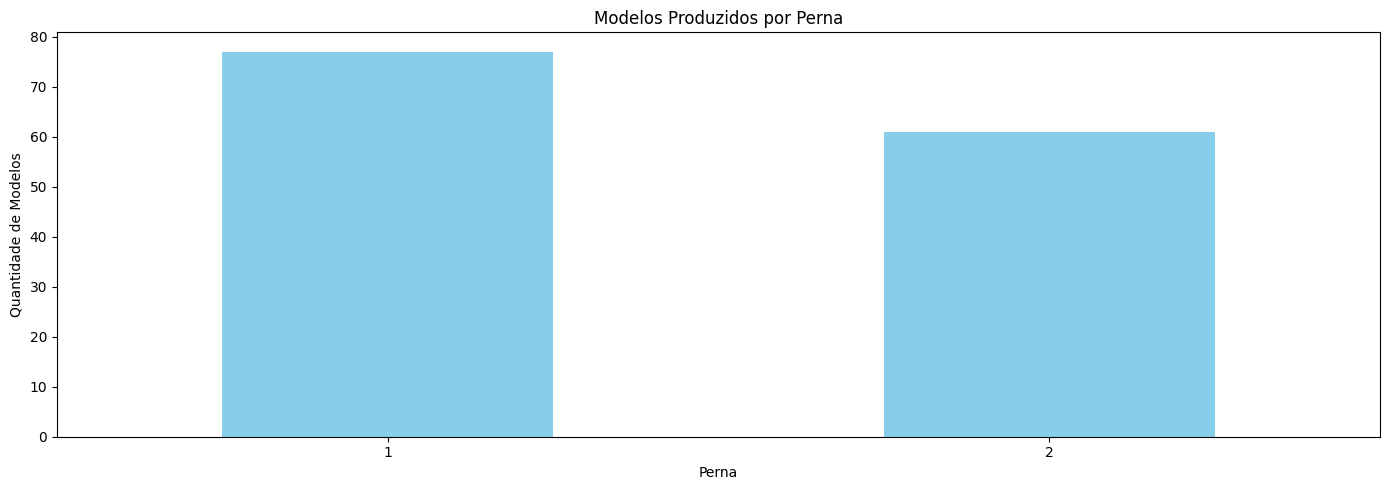

modelo
Accelo               40
Atego quinta roda    26
Atego                21
Atego (ATP)          20
Actros               18
Atego 8x2 e 8x4      12
Axor (ATP +)          1
Name: nome, dtype: int64


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)


               nome        modelo  perna  entrada_total  saida_total
0         Accelo_10        Accelo      1         3630.0       8706.0
1        Accelo_100        Accelo      1        33988.0      34911.0
2        Accelo_101        Accelo      2        34318.0      46582.0
3        Accelo_106        Accelo      1        36626.0      37549.0
4        Accelo_107        Accelo      2        36956.0      47848.0
..              ...           ...    ...            ...          ...
133        Atego_78         Atego      1        26070.0      43496.0
134        Atego_81         Atego      1        27060.0      45995.0
135        Atego_94         Atego      1        32008.0      33425.0
136        Atego_99         Atego      2        33658.0      46094.0
137  Axor (ATP +)_0  Axor (ATP +)      1          330.0       2194.0

[138 rows x 5 columns]


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


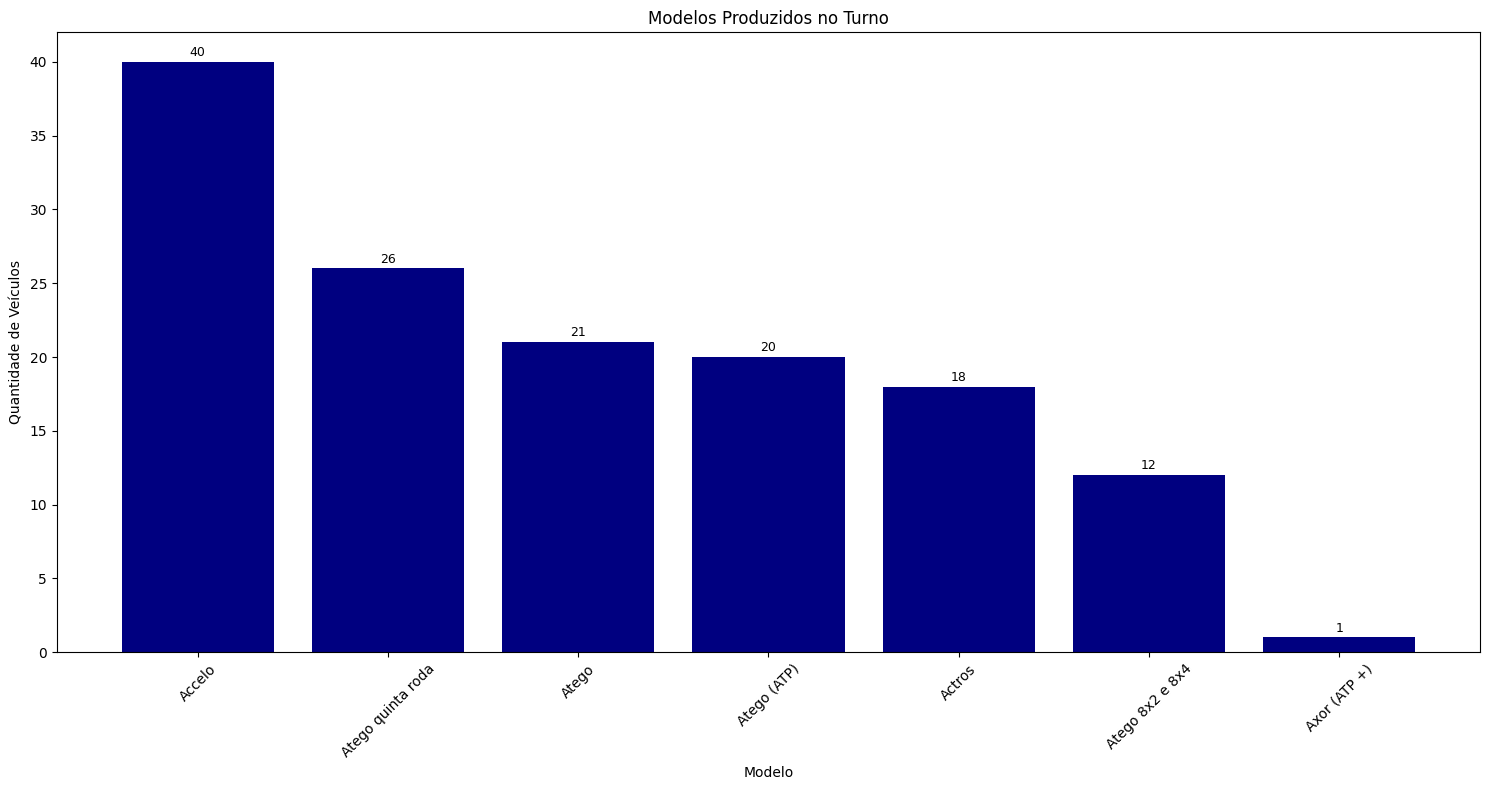

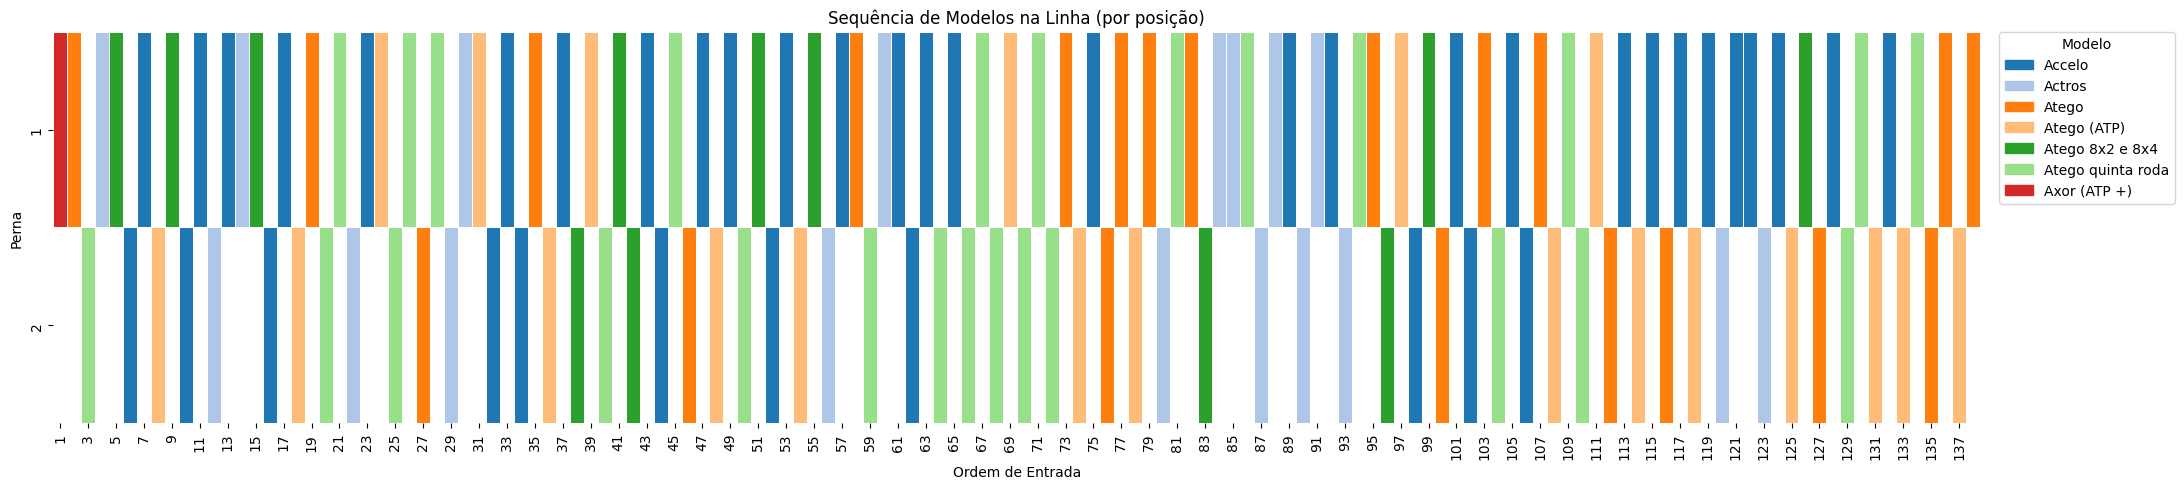

C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-01/log_2025-04-01.csv

--- Análise de Carga de Trabalho (Resultado da Simulação) ---
Perna 1: Carga de trabalho equivalente a 12.99 operadores trabalhando constantemente.
Perna 2: Carga de trabalho equivalente a 14.77 operadores trabalhando constantemente.
----------------------------------------------------------
📝 PDF de resumo salvo em: logs_C3/2025-04-01/resumo_simulacao_2025-04-01.pdf

🎉 Processo de simulação concluído para todos os dias selecionados!

🔄 Processando o dia: 2025-04-02


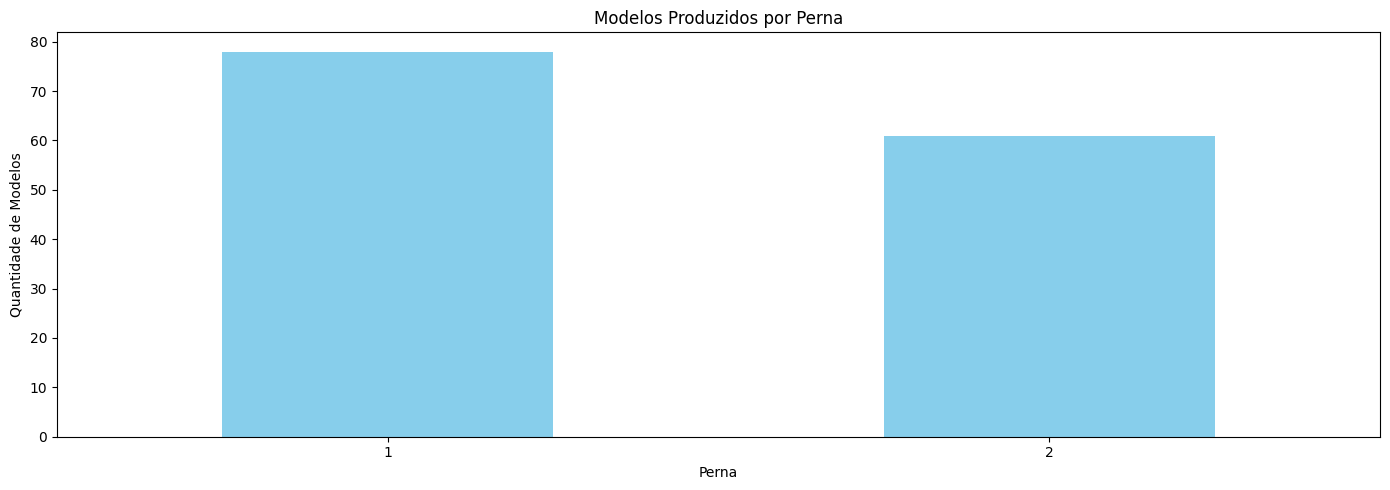

modelo
Accelo               45
Atego quinta roda    34
Atego (ATP)          23
Actros               17
Atego                15
Atego 8x2 e 8x4       5
Name: nome, dtype: int64


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0      Accelo_0  Accelo      1          330.0       3904.0
1    Accelo_100  Accelo      2        33988.0      41547.0
2    Accelo_102  Accelo      2        34648.0      42035.0
3    Accelo_104  Accelo      2        35308.0      42523.0
4    Accelo_109  Accelo      1        36958.0      37881.0
..          ...     ...    ...            ...          ...
134    Atego_62   Atego      2        21448.0      45130.0
135    Atego_85   Atego      2        29038.0      37352.0
136    Atego_87   Atego      1        29698.0      30740.0
137    Atego_90   Atego      2        30688.0      38528.0
138    Atego_95   Atego      1        32338.0      33755.0

[139 rows x 5 columns]


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


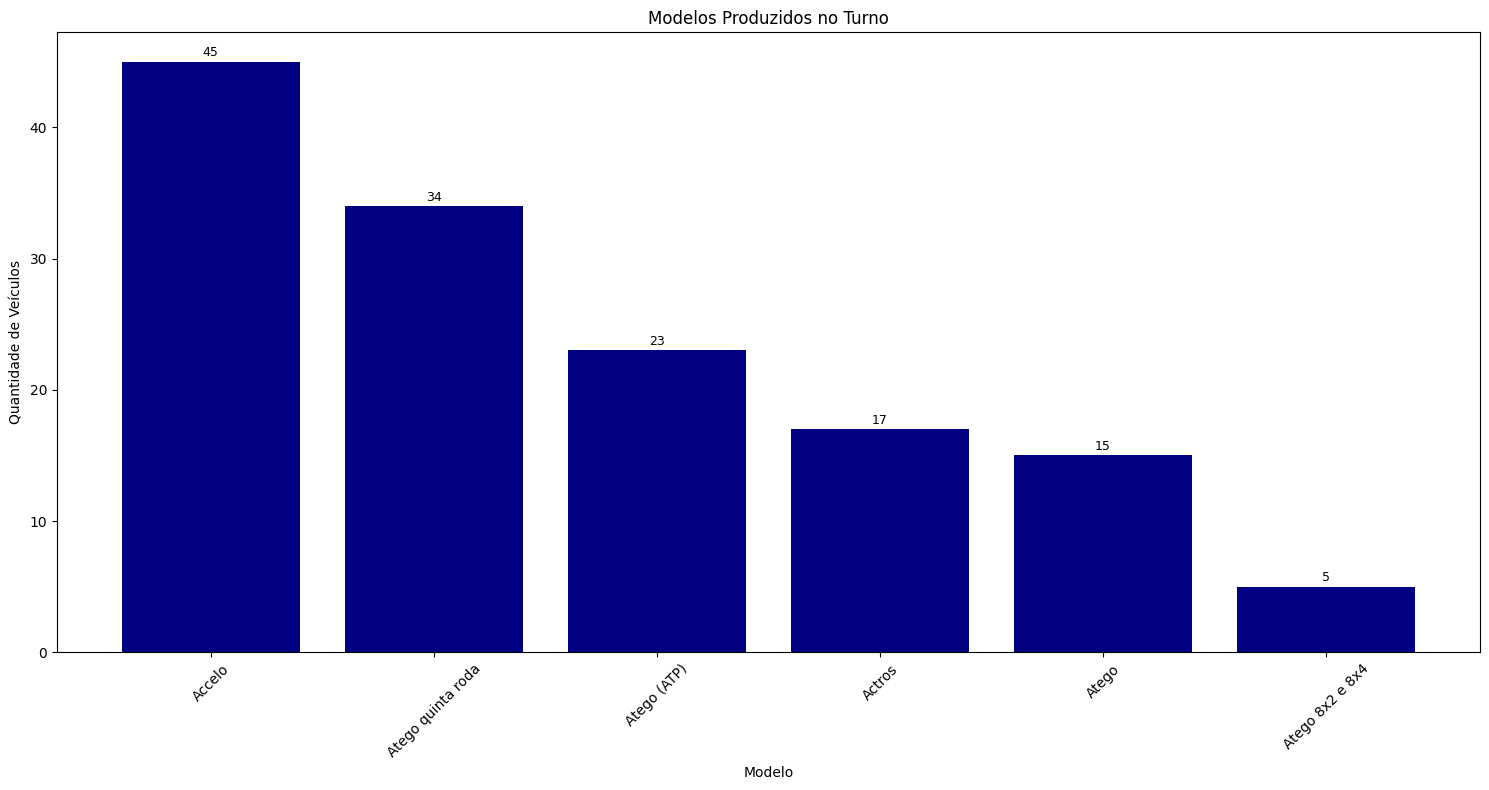

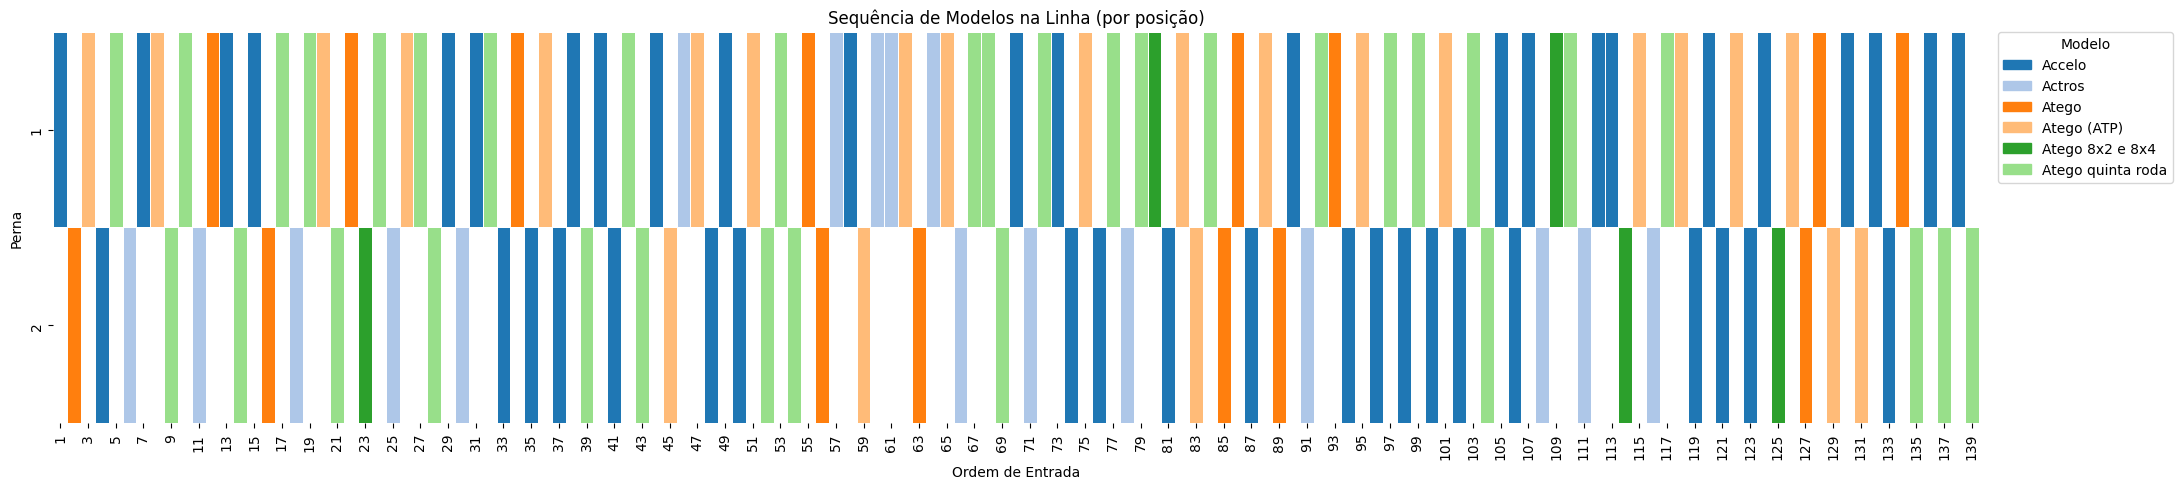

C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-02/log_2025-04-02.csv

--- Análise de Carga de Trabalho (Resultado da Simulação) ---
Perna 1: Carga de trabalho equivalente a 14.08 operadores trabalhando constantemente.
Perna 2: Carga de trabalho equivalente a 14.09 operadores trabalhando constantemente.
----------------------------------------------------------
📝 PDF de resumo salvo em: logs_C3/2025-04-02/resumo_simulacao_2025-04-02.pdf

🎉 Processo de simulação concluído para todos os dias selecionados!

🔄 Processando o dia: 2025-04-03


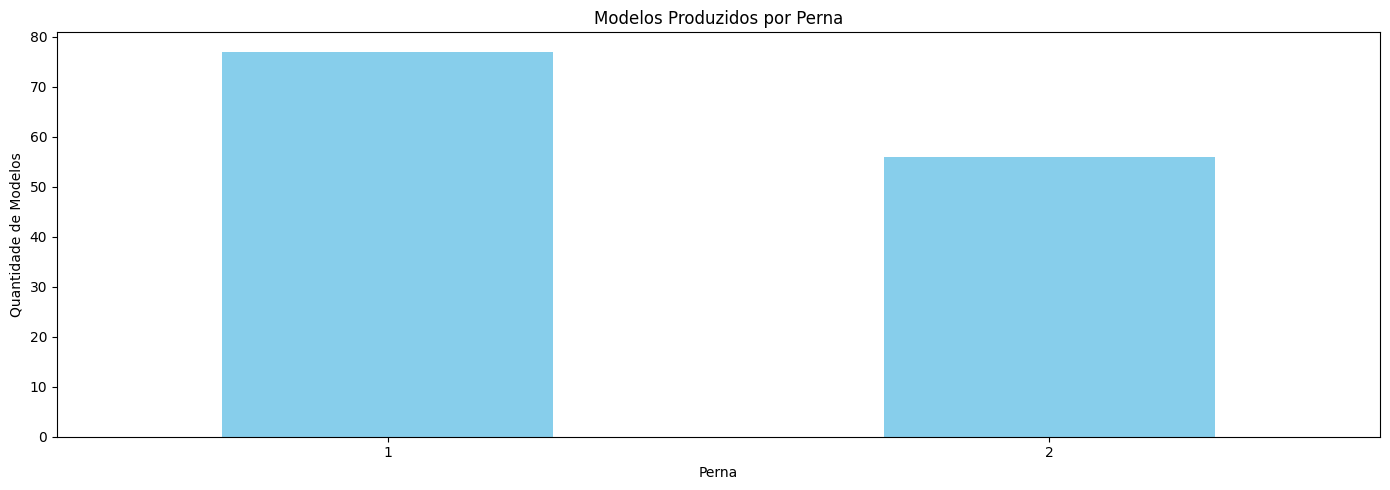

modelo
Accelo               31
Atego                27
Atego quinta roda    25
Actros               24
Atego (ATP)          22
Atego 8x2 e 8x4       3
Arocs                 1
Name: nome, dtype: int64


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)


           nome  modelo  perna  entrada_total  saida_total
0      Accelo_0  Accelo      1          330.0       4629.0
1    Accelo_101  Accelo      1        36950.0      37873.0
2    Accelo_108  Accelo      1        39260.0      40183.0
3    Accelo_112  Accelo      1        40580.0      41503.0
4     Accelo_12  Accelo      2         5606.0      13905.0
..          ...     ...    ...            ...          ...
128    Atego_80   Atego      1        30020.0      31062.0
129    Atego_86   Atego      2        32000.0      39063.0
130    Atego_91   Atego      2        33650.0      40099.0
131    Atego_96   Atego      1        35300.0      36387.0
132    Atego_97   Atego      2        35630.0      42354.0

[133 rows x 5 columns]


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


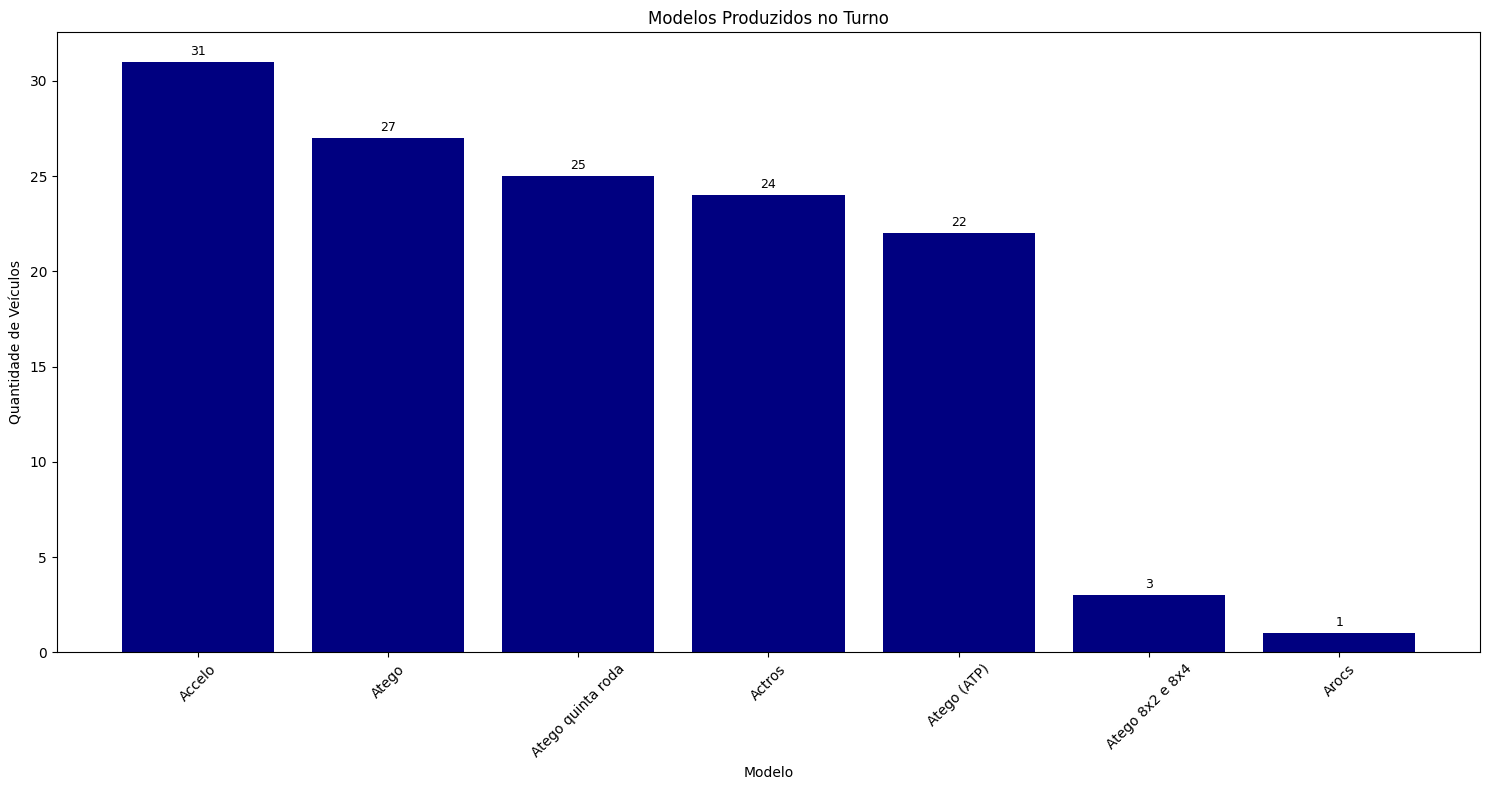

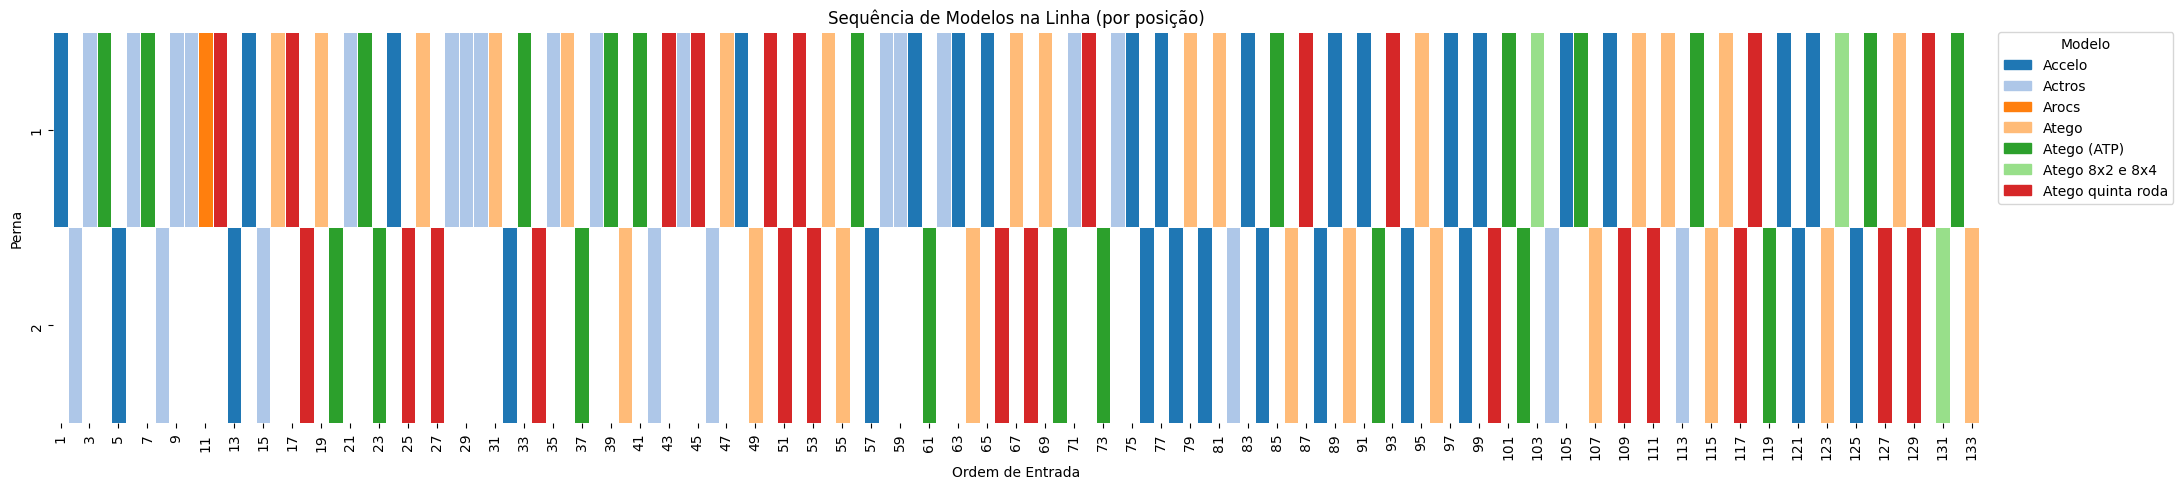

C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-03/log_2025-04-03.csv

--- Análise de Carga de Trabalho (Resultado da Simulação) ---
Perna 1: Carga de trabalho equivalente a 13.43 operadores trabalhando constantemente.
Perna 2: Carga de trabalho equivalente a 10.81 operadores trabalhando constantemente.
----------------------------------------------------------
📝 PDF de resumo salvo em: logs_C3/2025-04-03/resumo_simulacao_2025-04-03.pdf

🎉 Processo de simulação concluído para todos os dias selecionados!

🔄 Processando o dia: 2025-04-04


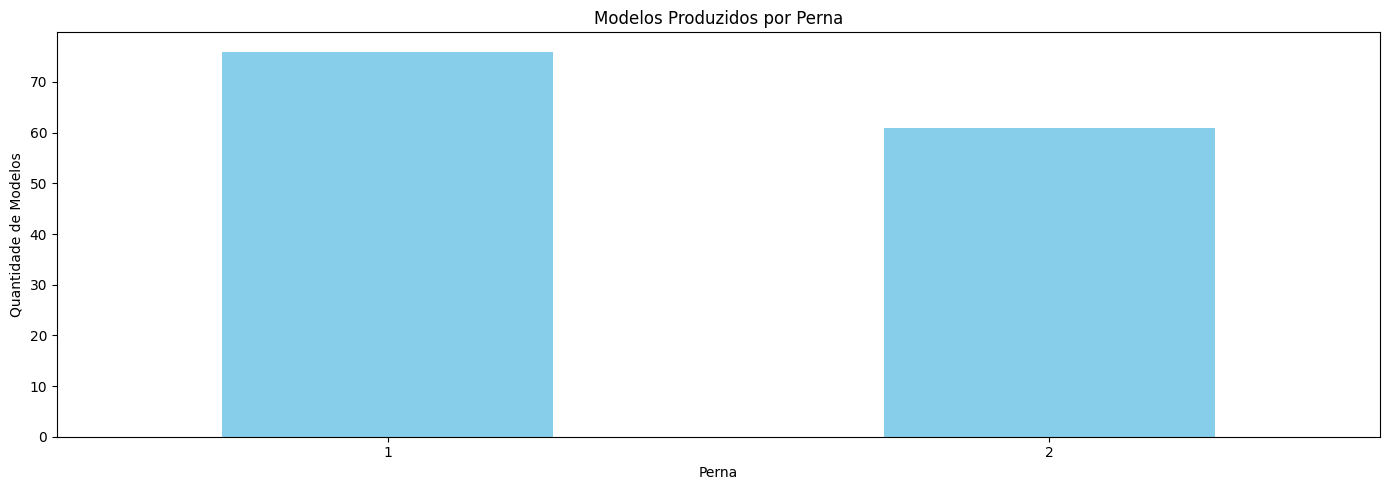

modelo
Atego                41
Accelo               31
Atego (ATP)          20
Actros               19
Atego quinta roda    16
Atego 8x2 e 8x4       8
Arocs                 1
Axor (ATP +)          1
Name: nome, dtype: int64


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\3002892121.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(modelos_produzidos.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\2126072313.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(media_perna.index, rotation=45)


                nome        modelo  perna  entrada_total   saida_total
0           Accelo_1        Accelo      2          660.0   4655.666667
1         Accelo_110        Accelo      1        36630.0  37657.000000
2         Accelo_112        Accelo      1        37290.0  38213.000000
3         Accelo_113        Accelo      2        37620.0  47859.000000
4         Accelo_115        Accelo      2        38280.0  48453.000000
..               ...           ...    ...            ...           ...
132         Atego_89         Atego      2        29700.0  39707.000000
133          Atego_9         Atego      2         3300.0   9431.000000
134         Atego_96         Atego      1        32010.0  33052.000000
135         Atego_97         Atego      2        32340.0  42643.000000
136  Axor (ATP +)_29  Axor (ATP +)      1         9900.0  17232.000000

[137 rows x 5 columns]


C:\Users\metae\AppData\Local\Temp\ipykernel_20504\1391178494.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_num = pivot.applymap(lambda x: modelo_to_int.get(x, np.nan))


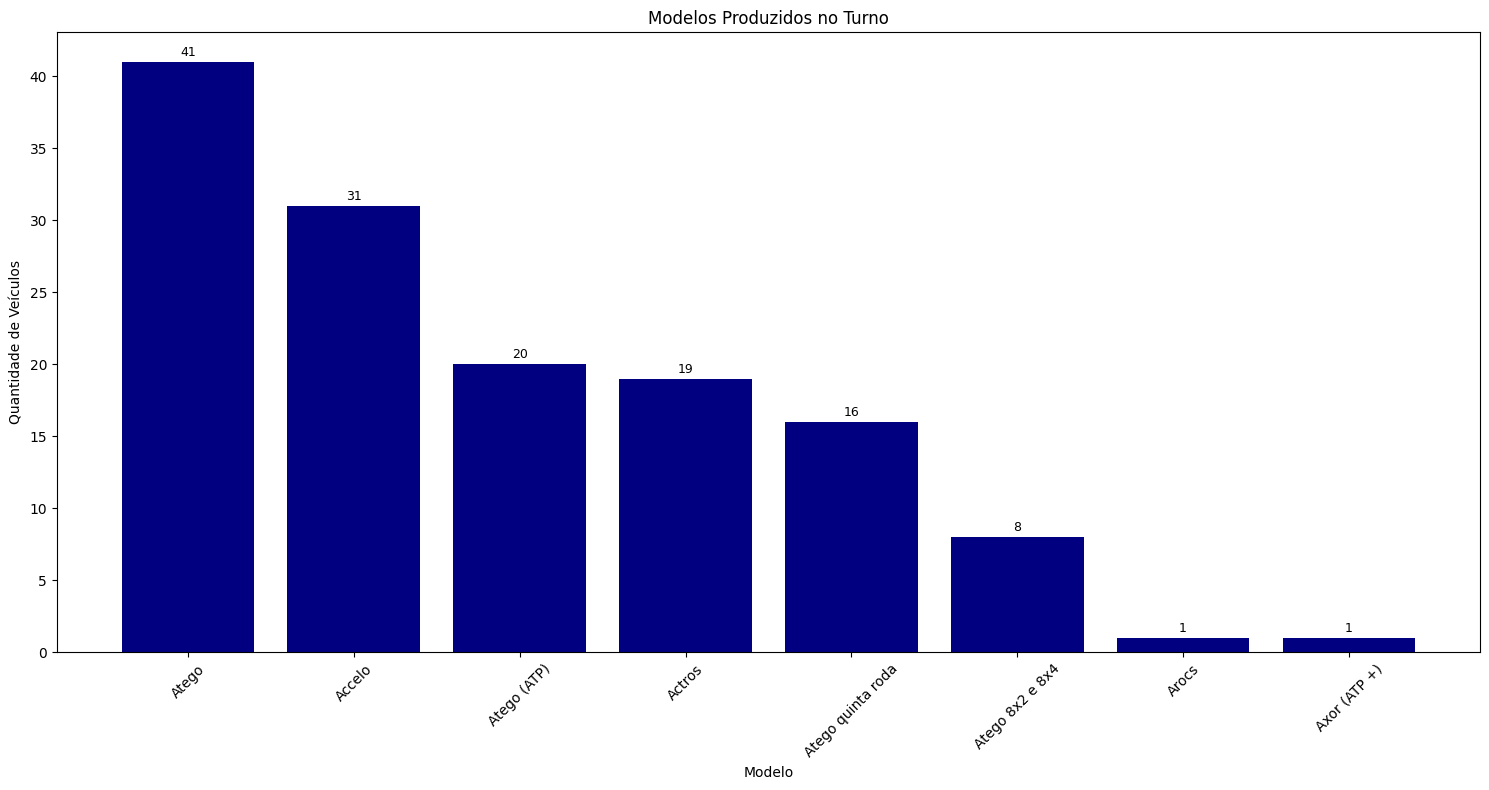

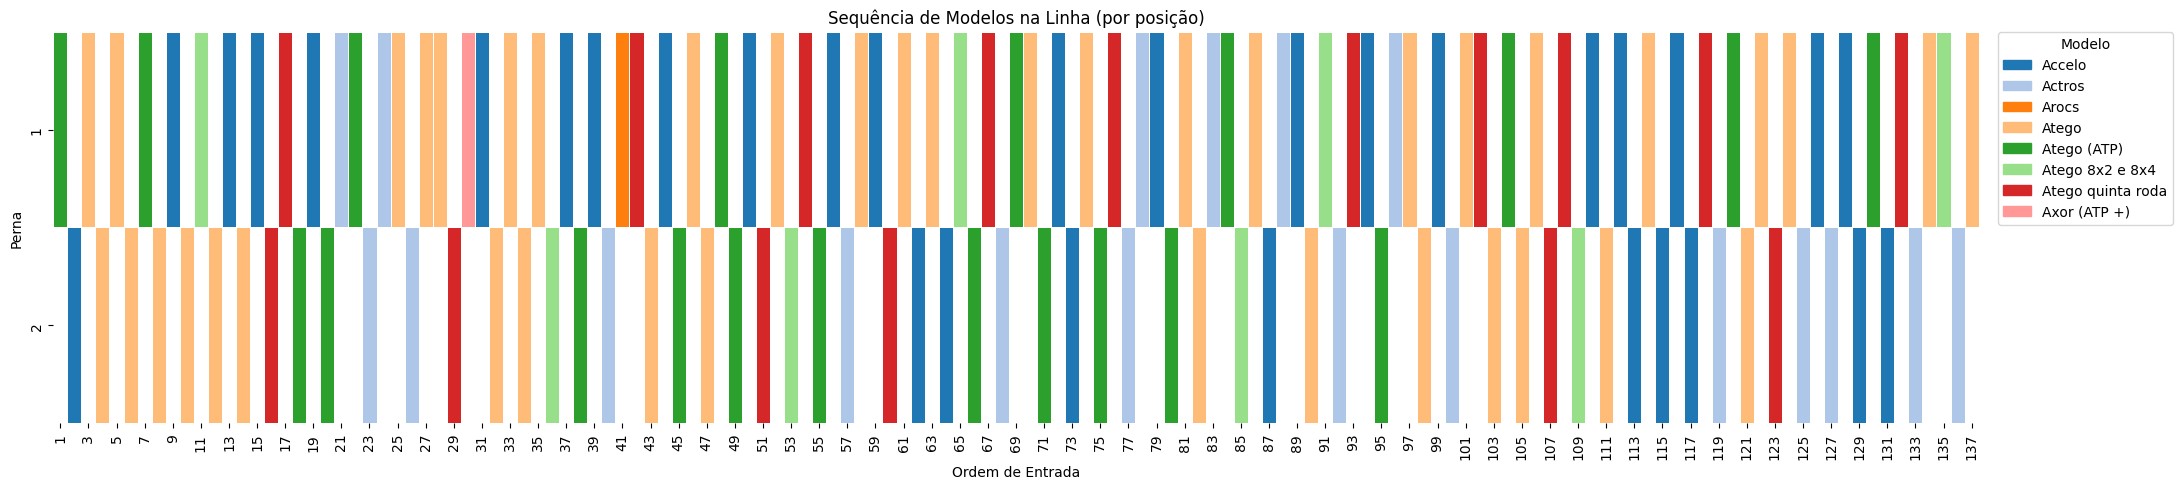

C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3", ax=ax)
C:\Users\metae\AppData\Local\Temp\ipykernel_20504\4008869961.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


📁 Log salvo em: logs_C3/2025-04-04/log_2025-04-04.csv

--- Análise de Carga de Trabalho (Resultado da Simulação) ---
Perna 1: Carga de trabalho equivalente a 13.42 operadores trabalhando constantemente.
Perna 2: Carga de trabalho equivalente a 14.31 operadores trabalhando constantemente.
----------------------------------------------------------
📝 PDF de resumo salvo em: logs_C3/2025-04-04/resumo_simulacao_2025-04-04.pdf

🎉 Processo de simulação concluído para todos os dias selecionados!


In [100]:
# Lê o arquivo Excel com os dados de produção
df_sequencia = pd.read_excel("todas_sequencias.xlsx")

# Converte a coluna de data
df_sequencia['Data Entrada Linha'] = pd.to_datetime(df_sequencia['Data Entrada Linha'])

# Define data de início (ajuste conforme necessário!)
data_inicio = date(2025, 4, 1)

# Obtém os dias únicos ordenados
dias_unicos = sorted(df_sequencia['Data Entrada Linha'].dt.date.unique())

# Filtra os dias a partir da data de início
dias_filtrados = [d for d in dias_unicos if d >= data_inicio][:4]

print(f"🗓️ Dias selecionados (10 a partir de {data_inicio}):")
for d in dias_filtrados:
    print(f"  - {d}")

# Cria pasta principal se não existir
os.makedirs("logs_C3", exist_ok=True)

# Salvando tempo por atividades
figs = plot_tempo_atividades_por_modelo(MODELOS_CSV, ATIVIDADES, get_process_times_from_csv)
for i, fig in enumerate(figs, start=1):
    fig.savefig(f"logs_C3/atividades_modelo{i}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)


# Loop por dia
for dia in dias_filtrados:
    log_entrada_saida = []
    print(f"\n🔄 Processando o dia: {dia}")
    
    pasta_dia = f"logs_C3/{dia}"
    nome_csv = f"{pasta_dia}/log_{dia}.csv"

    # Se já tiver o CSV salvo, pula o dia
    if os.path.exists(nome_csv):
        print(f"✅ Já processado: {dia}")
        continue

    os.makedirs(pasta_dia, exist_ok=True)

    # Filtra dados do dia
    df_dia = df_sequencia[df_sequencia['Data Entrada Linha'].dt.date == dia].copy()
    df_dia['Baumuster_7dig'] = df_dia['Baumuster'].astype(str).str[:7]
    sequencia_modelos = df_dia['Baumuster_7dig'].tolist()

    # Simula
    
    df_log = simulacao_linha(sequencia_modelos, MODELOS_CSV, POSTOS, TAKT_TIME, TURN_DURATION)

    # Gráficos e salvamento

    fig1 = plot_modelos_por_perna(df_log)
    fig1.savefig(f"{pasta_dia}/modelos_por_perna.png")

    fig2 = plot_modelos_produzidos(df_log)
    fig2.savefig(f"{pasta_dia}/modelos_produzidos.png")

    figs = plot_ocupacao_por_modelo_heatmap(df_log, TURN_DURATION)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/ocupacao_modelo_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)
    
    figs = plot_duracao_media_por_posto(df_log)
    for i, fig in enumerate(figs, start=1):
        fig.savefig(f"{pasta_dia}/duracao_media_por_posto_P{i}.png", dpi=300, bbox_inches="tight")
        plt.close(fig)

    fig5 = plot_sequencia_modelos_heatmap(df_log)
    fig5.savefig(f"{pasta_dia}/sequencia_dia.png", dpi=300, bbox_inches='tight')
    plt.close(fig5)

    fig6 = plot_boxplot_tempo_total_por_modelo(df_log)
    fig6.savefig(f"{pasta_dia}/boxplot_tempo_total_por_modelo.png", dpi=300, bbox_inches='tight')
    plt.close(fig6)


    # Salva CSV com o log
    df_log.to_csv(nome_csv, index=False)
    print(f"📁 Log salvo em: {nome_csv}")
    
    carga_operadores_real = analisar_carga_trabalho_real(df_log, TURN_DURATION)

    # 2. Gera o PDF de resumo passando a análise de operadores
    caminho_pdf = f"{pasta_dia}/resumo_simulacao_{dia}.pdf"
    gerar_resumo_pdf(df_log, TURN_DURATION, carga_operadores_real, caminho_pdf)

    print("\n🎉 Processo de simulação concluído para todos os dias selecionados!")


In [101]:
# # Tempo total por modelo individual (nome), com identificação do tipo de modelo (ex: Accelo, Atego)
# df_tempo_modelos = df_log.groupby("nome").agg(
#     modelo=("modelo", "first"),
#     tempo_total_min=("duracao", "sum")
# ).reset_index()
# df_tempo_modelos["tempo_total_min"] = df_tempo_modelos["tempo_total_min"] / 60  # segundos → minutos

# # Boxplot
# plt.figure(figsize=(10, 5))
# sns.boxplot(data=df_tempo_modelos, x="modelo", y="tempo_total_min", palette="Set3")
# plt.title("Distribuição do Tempo de Produção por Modelo")
# plt.xlabel("Modelo")
# plt.ylabel("Tempo Total de Produção (minutos)")
# plt.xticks(rotation=45)
# plt.show()